In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


# Load data

In [3]:
# Load merged training data (normalized)
import pandas as pd

df = pd.read_csv('NewData/merged_train.csv')

print("Data shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Ensure a numeric time column is available
if 'Time' in df.columns:
    try:
        df['time_seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()
    except Exception:
        df['time_seconds'] = pd.to_numeric(df['Time'], errors='coerce').fillna(0.0)
elif 'time_seconds' not in df.columns:
    df['time_seconds'] = 0.0

# Quick peek
df.head()

Data shape: (32222, 33)

Columns: ['Point_ID', 'Year', 'Track', 'Session', 'Driver', 'Lap_Time', 'Time', 'Distance', 'X', 'Y', 'Speed', 'Throttle', 'Brake', 'nGear', 'RPM', 'DRS', 'X_norm', 'Y_norm', 'trk_match_dist', 'trk_x_m', 'trk_y_m', 'trk_left_x_m', 'trk_left_y_m', 'trk_right_x_m', 'trk_right_y_m', 'trk_left_x_norm', 'trk_left_y_norm', 'trk_right_x_norm', 'trk_right_y_norm', 'trk_curvature', 'trk_centroid_x_norm', 'trk_centroid_y_norm', 'tire_wear']


,Point_ID,Year,Track,Session,Driver,Lap_Time,Time,Distance,X,Y,...,trk_right_y_m,trk_left_x_norm,trk_left_y_norm,trk_right_x_norm,trk_right_y_norm,trk_curvature,trk_centroid_x_norm,trk_centroid_y_norm,tire_wear,time_seconds
0,2018_Budapest_Q_VET_1,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00,0.266667,-86.904435,-61.332845,...,-4.657720,0.498245,0.082182,0.484044,0.066956,0.060680,0.491144,0.074569,0.034895,0.000
1,2018_Budapest_Q_VET_2,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.040000,3.334915,-90.700000,-58.200000,...,-4.364222,0.494662,0.084817,0.480457,0.069593,0.034450,0.487559,0.077205,0.019936,0.040
2,2018_Budapest_Q_VET_3,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.280000,21.966667,-115.547753,-37.706121,...,-2.604899,0.473142,0.100635,0.458951,0.085401,0.051289,0.466047,0.093018,0.030806,0.280
3,2018_Budapest_Q_VET_4,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.340000,26.690815,-121.600000,-32.700000,...,-2.019190,0.465963,0.105903,0.451779,0.090664,0.044268,0.458871,0.098284,0.026876,0.340
4,2018_Budapest_Q_VET_5,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.519000,40.887500,-138.382712,-18.760780,...,-0.848518,0.451598,0.116431,0.437428,0.101183,0.026751,0.444513,0.108807,0.016766,0.519


In [4]:
print(df.isnull().sum())
print(df.describe())

Point_ID               0
Year                   0
Track                  0
Session                0
Driver                 0
Lap_Time               0
Time                   0
Distance               0
X                      0
Y                      0
Speed                  0
Throttle               0
Brake                  0
nGear                  0
RPM                    0
DRS                    0
X_norm                 0
Y_norm                 0
trk_match_dist         0
trk_x_m                0
trk_y_m                0
trk_left_x_m           0
trk_left_y_m           0
trk_right_x_m          0
trk_right_y_m          0
trk_left_x_norm        0
trk_left_y_norm        0
trk_right_x_norm       0
trk_right_y_norm       0
trk_curvature          0
trk_centroid_x_norm    0
trk_centroid_y_norm    0
tire_wear              0
time_seconds           0
dtype: int64
               Year      Distance             X             Y         Speed  \
count  32222.000000  32222.000000  32222.000000  32222.000

In [5]:
# Feature configuration: use normalized track features + tire_wear as inputs; outputs are normalized positions and time
input_features = ['trk_centroid_x_norm','trk_centroid_y_norm','trk_right_x_norm','trk_right_y_norm','trk_left_x_norm','trk_left_y_norm','tire_wear']
output_features = ['X_norm','Y_norm','time_seconds']
seq_length = 350 # target sequence length for sliding-window generation

# Create RNN Sequences

In [6]:
def create_sequences_by_id(data, seq_len, input_features, output_features):
    """Create sequences grouped by lap identifier using Point_ID prefix rule.

    - Lap id is everything before the final underscore+integer in Point_ID.
    - Each lap is sorted by Distance (preferred) or time_seconds if Distance missing.
    - Sliding windows of length seq_len are emitted; target y is the step immediately after the window.
    """
    data = data.copy()
    data["Point_Base"] = data["Point_ID"].astype(str).str.rsplit("_", n=1).str[0]

    X, y = [], []

    for _, group in data.groupby("Point_Base"):
        # prefer sorting by Distance, otherwise time_seconds, else Point_ID order
        if 'Distance' in group.columns:
            group = group.sort_values('Distance').reset_index(drop=True)
        elif 'time_seconds' in group.columns:
            group = group.sort_values('time_seconds').reset_index(drop=True)
        else:
            group = group.sort_values('Point_ID').reset_index(drop=True)

        n = len(group)
        if n <= seq_len:
            # skip laps shorter than or equal to seq_len (no next-step target)
            continue

        # sliding window
        for i in range(n - seq_len):
            X.append(group[input_features].iloc[i:i+seq_len].values.astype(float))
            y.append(group[output_features].iloc[i+seq_len].values.astype(float))

    if len(X) == 0:
        return np.empty((0, seq_len, len(input_features))), np.empty((0, len(output_features)))

    return np.array(X), np.array(y)

In [7]:
X, y = create_sequences_by_id(df, seq_length, input_features, output_features)

print(f"Sequence shapes:")
print(f"Input (X): {X.shape}")
print(f"Output (y): {y.shape}")

Sequence shapes:
Input (X): (15772, 350, 7)
Output (y): (15772, 3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 12617 samples
Test set: 3155 samples


In [9]:
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = input_scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = input_scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Convert the 'Time' column (index 2) of y_train to total seconds (float)
y_train_processed = y_train.copy()
y_train_processed[:, 2] = np.array([pd.to_timedelta(t).total_seconds() for t in y_train_processed[:, 2]])
y_train_processed = y_train_processed.astype(float) # Ensure all elements are float

# Convert the 'Time' column (index 2) of y_test to total seconds (float)
y_test_processed = y_test.copy()
y_test_processed[:, 2] = np.array([pd.to_timedelta(t).total_seconds() for t in y_test_processed[:, 2]])
y_test_processed = y_test_processed.astype(float) # Ensure all elements are float

y_train_scaled = output_scaler.fit_transform(y_train_processed)
y_test_scaled = output_scaler.transform(y_test_processed)

# Train Model

In [10]:
model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True,
                      input_shape=(seq_length, len(input_features)),
                      name='lstm_1'),
    keras.layers.Dropout(0.2, name='dropout_1'),

    keras.layers.LSTM(32, return_sequences=False, name='lstm_2'),
    keras.layers.Dropout(0.2, name='dropout_2'),

    keras.layers.Dense(32, activation='relu', name='dense_1'),
    keras.layers.Dense(len(output_features), name='output')
])

print("Model Architecture:")
model.summary()

Model Architecture:


c:\Users\reeka\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 350, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,003 (125.01 KB)

 Trainable params: 32,003 (125.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - loss: 0.0581 - mae: 0.1495 - val_loss: 0.0040 - val_mae: 0.0452
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - loss: 0.0581 - mae: 0.1495 - val_loss: 0.0040 - val_mae: 0.0452
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - loss: 0.0148 - mae: 0.0847 - val_loss: 0.0028 - val_mae: 0.0390
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - loss: 0.0148 - mae: 0.0847 - val_loss: 0.0028 - val_mae: 0.0390
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - loss: 0.0119 - mae: 0.0745 - val_loss: 0.0021 - val_mae: 0.0320
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - loss: 0.0119 - mae: 0.0745 - val_loss: 0.0021 - val_mae: 0.0320
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - loss: 0.0106 - mae: 0.0694 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - loss: 0.0106 - mae: 0.0694 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f"\nTest Results:")
print(f"  Loss (MSE): {test_loss:.4f}")
print(f"  MAE: {test_mae:.4f}")


Test Results:
  Loss (MSE): 0.0012
  MAE: 0.0254


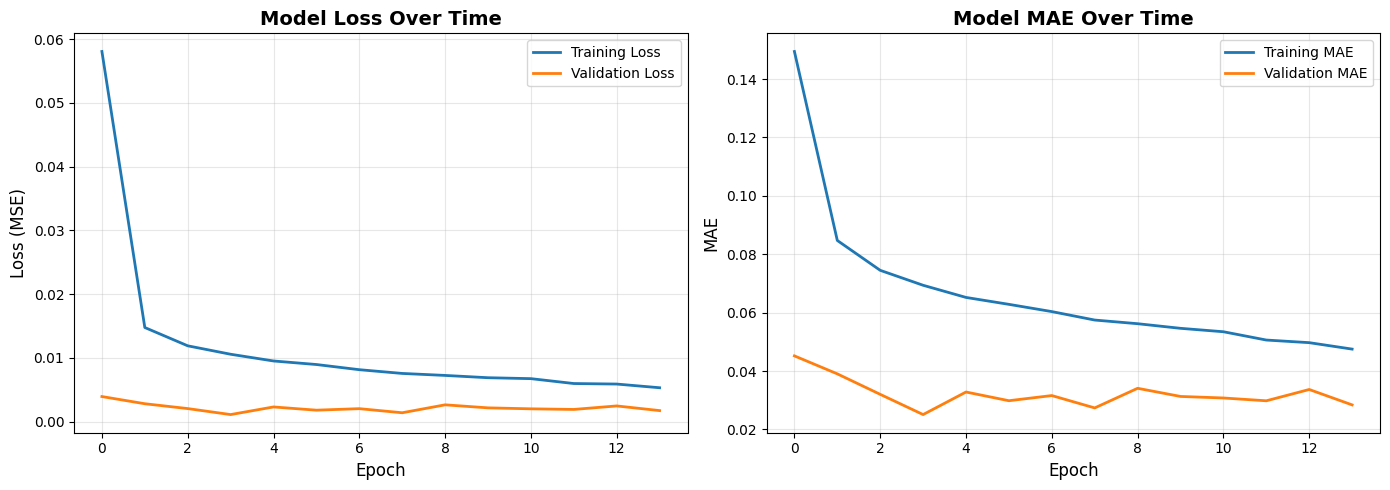

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Model MAE Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [15]:
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

print(f"Generated {len(y_pred)} predictions")
print(f"\nSample prediction:")
print(f"  X: {y_pred[0, 0]:.2f} m")
print(f"  Y: {y_pred[0, 1]:.2f} m")
print(f"  Time: {y_pred[0, 2]:.2f} s")

Generated 3155 predictions

Sample prediction:
  X: 0.60 m
  Y: 0.21 m
  Time: 0.00 s


In [16]:
model.save('f1_racing_line_model.h5')

with open('input_scaler.pkl', 'wb') as f:
    pickle.dump(input_scaler, f)

with open('output_scaler.pkl', 'wb') as f:
    pickle.dump(output_scaler, f)


In [18]:
# Single-sequence prediction test
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Try to use in-memory model/scalers if available, otherwise load from disk
try:
    model_to_use = model
except NameError:
    model_to_use = load_model('f1_racing_line_model.h5')

try:
    in_scaler = input_scaler
    out_scaler = output_scaler
except NameError:
    with open('input_scaler.pkl', 'rb') as f:
        in_scaler = pickle.load(f)
    with open('output_scaler.pkl', 'rb') as f:
        out_scaler = pickle.load(f)

# Pick a sample sequence from the test set (use X_test_scaled if present)
if 'X_test_scaled' in globals():
    sample_idx = 0
    sample_X = X_test_scaled[sample_idx:sample_idx+1]
    true_y = y_test_processed[sample_idx:sample_idx+1] if 'y_test_processed' in globals() else y_test[sample_idx:sample_idx+1]
else:
    # fallback: build a single sequence from df groups
    X_all, y_all = create_sequences_by_id(df, seq_length, input_features, output_features)
    if X_all.shape[0] == 0:
        raise RuntimeError('No sequences available to test. Reduce seq_length or check data.')
    sample_X = in_scaler.transform(X_all.reshape(-1, X_all.shape[-1])).reshape(X_all.shape)[0:1]
    true_y = y_all[0:1]

# Predict and inverse-transform
y_pred_scaled = model_to_use.predict(sample_X, verbose=0)
y_pred = out_scaler.inverse_transform(y_pred_scaled)

print('Predicted output (X_norm, Y_norm, time_seconds):', y_pred)
print('Ground-truth target                :', true_y[0])

# If time looks reasonable, also print time in seconds (third column)
print('\nPredicted time (s):', float(y_pred[0, 2]))
print('True time (s):', float(true_y[0, 2]))

Predicted output (X_norm, Y_norm, time_seconds): [[0.6004148  0.2126159  0.00078163]]
Ground-truth target                : [0.59648772 0.21516155 0.        ]

Predicted time (s): 0.0007816292345523834
True time (s): 0.0


Lap length n=563, seq_length=350, windows=563, coverage=100.00%


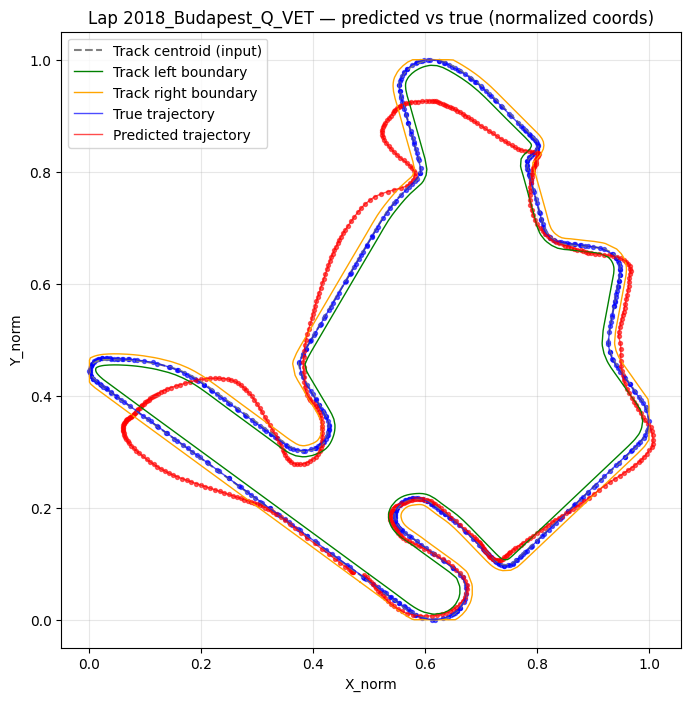

,Point_ID,pred_X_norm,pred_Y_norm,X_norm,Y_norm,time_seconds,trk_left_x_norm,trk_left_y_norm,trk_right_x_norm,trk_right_y_norm
0,2018_Budapest_Q_VET_1,0.470406,0.085034,0.492170,0.074446,0.000,0.498245,0.082182,0.484044,0.066956
1,2018_Budapest_Q_VET_2,0.470406,0.085034,0.488632,0.077038,0.040,0.494662,0.084817,0.480457,0.069593
2,2018_Budapest_Q_VET_3,0.470104,0.085264,0.465470,0.093996,0.280,0.473142,0.100635,0.458951,0.085401
3,2018_Budapest_Q_VET_4,0.467779,0.086992,0.459829,0.098139,0.340,0.465963,0.105903,0.451779,0.090664
4,2018_Budapest_Q_VET_5,0.463667,0.090006,0.444185,0.109673,0.519,0.451598,0.116431,0.437428,0.101183
...,...,...,...,...,...,...,...,...,...,...
75,2018_Budapest_Q_VET_76,0.070713,0.360279,0.007311,0.460415,10.040,0.013663,0.450868,0.001614,0.467492
76,2018_Budapest_Q_VET_77,0.072411,0.361636,0.008956,0.461809,10.139,0.013663,0.450868,0.001614,0.467492
77,2018_Budapest_Q_VET_78,0.073998,0.362882,0.011741,0.463614,10.280,0.016146,0.451959,0.007485,0.470170
78,2018_Budapest_Q_VET_79,0.075632,0.364382,0.015295,0.465285,10.440,0.019413,0.452939,0.013228,0.471928


In [22]:
# Slide the model across the full lap (predict every index by padding early windows)
import numpy as np
import pickle
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd

# Load/reuse model and scalers
try:
    model_to_use = model
except NameError:
    model_to_use = load_model('f1_racing_line_model.h5')
try:
    in_scaler = input_scaler
    out_scaler = output_scaler
except NameError:
    with open('input_scaler.pkl', 'rb') as f:
        in_scaler = pickle.load(f)
    with open('output_scaler.pkl', 'rb') as f:
        out_scaler = pickle.load(f)

# Ensure Point_Base present
if 'Point_Base' not in df.columns:
    df['Point_Base'] = df['Point_ID'].astype(str).str.rsplit('_', n=1).str[0]

# Pick a lap to inspect (first lap with length >= 5)
grouped = df.groupby('Point_Base')
lap_key = None
for k, g in grouped:
    if len(g) >= 5:
        lap_key = k
        break
if lap_key is None:
    raise RuntimeError('No lap found in data.')

# Prepare lap dataframe and sort
lap = grouped.get_group(lap_key).copy()
if 'Distance' in lap.columns:
    lap = lap.sort_values('Distance').reset_index(drop=True)
elif 'time_seconds' in lap.columns:
    lap = lap.sort_values('time_seconds').reset_index(drop=True)
else:
    lap = lap.reset_index(drop=True)

# Build padded windows so we can predict for every target index (0..n-1)
n = len(lap)
def build_padded_windows(lap, seq_length, input_features):
    windows = []
    target_idxs = []
    for target_idx in range(n):
        end = target_idx - 1
        start = end - seq_length + 1
        if start >= 0:
            window = lap[input_features].iloc[start:end+1].values.astype(float)
        else:
            pad_n = -start
            pad_row = lap[input_features].iloc[0].values.astype(float)
            pad = np.tile(pad_row.reshape(1, -1), (pad_n, 1))
            if end >= 0:
                body = lap[input_features].iloc[0:end+1].values.astype(float)
                window = np.vstack([pad, body])
            else:
                window = pad
        # ensure shape (seq_length, features)
        assert window.shape[0] == seq_length, f'window length {window.shape[0]} != seq_length {seq_length}'
        windows.append(window)
        target_idxs.append(target_idx)
    return np.array(windows), np.array(target_idxs)

X_windows, target_idxs = build_padded_windows(lap, seq_length, input_features)
print(f'Lap length n={n}, seq_length={seq_length}, windows={X_windows.shape[0]}, coverage={X_windows.shape[0]/n:.2%}')

# Scale inputs the same way as training
X_reshaped = X_windows.reshape(-1, X_windows.shape[-1])
X_scaled = in_scaler.transform(X_reshaped).reshape(X_windows.shape)

# Batch predict and inverse-transform outputs
y_pred_scaled = model_to_use.predict(X_scaled, verbose=0)
y_pred = out_scaler.inverse_transform(y_pred_scaled)  # shape (n, len(output_features))

# Create results DataFrame aligned to full lap indices
pred_df = lap.reset_index(drop=True).copy()
pred_df['pred_X_norm'] = np.nan
pred_df['pred_Y_norm'] = np.nan
# place predictions at their target indices
pred_df.loc[target_idxs, 'pred_X_norm'] = y_pred[:, 0]
pred_df.loc[target_idxs, 'pred_Y_norm'] = y_pred[:, 1]

# include boundary columns (where available)
for col in ['trk_left_x_norm','trk_left_y_norm','trk_right_x_norm','trk_right_y_norm','trk_centroid_x_norm','trk_centroid_y_norm']:
    if col not in pred_df.columns:
        pred_df[col] = np.nan

# Plot full lap: centroid and boundaries as context, true full trajectory, and predicted points for every index
plt.figure(figsize=(8,8))
if pred_df['trk_centroid_x_norm'].notna().any() and pred_df['trk_centroid_y_norm'].notna().any():
    plt.plot(pred_df['trk_centroid_x_norm'], pred_df['trk_centroid_y_norm'], color='gray', linestyle='--', label='Track centroid (input)')
if pred_df['trk_left_x_norm'].notna().any() and pred_df['trk_left_y_norm'].notna().any():
    plt.plot(pred_df['trk_left_x_norm'], pred_df['trk_left_y_norm'], color='green', linestyle='-', linewidth=1, label='Track left boundary')
if pred_df['trk_right_x_norm'].notna().any() and pred_df['trk_right_y_norm'].notna().any():
    plt.plot(pred_df['trk_right_x_norm'], pred_df['trk_right_y_norm'], color='orange', linestyle='-', linewidth=1, label='Track right boundary')
# true full lap trajectory
plt.plot(pred_df['X_norm'], pred_df['Y_norm'], '-', color='blue', linewidth=1, alpha=0.7, label='True trajectory')
# predicted points (may include early indices due to padding)
plt.plot(pred_df['pred_X_norm'], pred_df['pred_Y_norm'], '-', color='red', linewidth=1, alpha=0.7, label='Predicted trajectory')
plt.scatter(pred_df['X_norm'], pred_df['Y_norm'], s=8, c='blue', alpha=0.6)
plt.scatter(pred_df['pred_X_norm'], pred_df['pred_Y_norm'], s=8, c='red', alpha=0.6)
plt.legend()
plt.title(f'Lap {lap_key} — predicted vs true (normalized coords)')
plt.xlabel('X_norm')
plt.ylabel('Y_norm')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()

# Show head of results for inspection
display_columns = ['Point_ID','pred_X_norm','pred_Y_norm'] + output_features + ['trk_left_x_norm','trk_left_y_norm','trk_right_x_norm','trk_right_y_norm']
display(pred_df[display_columns].head(80))